In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset-fp-deep-learning/video_files_paths.npy
/kaggle/input/dataset-fp-deep-learning/features_test.npy
/kaggle/input/dataset-fp-deep-learning/labels_train.npy
/kaggle/input/dataset-fp-deep-learning/features_train.npy
/kaggle/input/dataset-fp-deep-learning/labels_test.npy
/kaggle/input/dataset-fp-deep-learning/test_indices.npy


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from base64 import b64encode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML, display
from tqdm.notebook import tqdm
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import TimesformerModel, TimesformerConfig
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2025-06-04 09:36:37.928060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749029798.153101      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749029798.223193      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
features_test = np.load('/kaggle/input/dataset-fp-deep-learning/features_test.npy')
features_train = np.load('/kaggle/input/dataset-fp-deep-learning/features_train.npy')
labels_test = np.load('/kaggle/input/dataset-fp-deep-learning/labels_test.npy')
labels_train = np.load('/kaggle/input/dataset-fp-deep-learning/labels_train.npy')
test_indices = np.load('/kaggle/input/dataset-fp-deep-learning/test_indices.npy')
video_files_paths = np.load('/kaggle/input/dataset-fp-deep-learning/video_files_paths.npy')

In [4]:
print(features_train.shape, features_test.shape)
print(labels_train.shape, labels_test.shape)

(1600, 16, 112, 112, 3) (400, 16, 112, 112, 3)
(1600, 2) (400, 2)


# Making the Dataset and DataLoader Object

In [5]:
class ViolenceDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    x = self.features[idx]
    x = torch.from_numpy(x).permute(0, 3, 1, 2).float()
    y = torch.tensor(self.labels[idx])
    return x, y


train_dataset = ViolenceDataset(features_train, labels_train)
test_dataset = ViolenceDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Model

In [6]:
def interpolate_pos_encoding_1d(old_posemb, new_posemb):
    cls_token = old_posemb[:, :1, :]  # (1, 1, C)
    old_tokens = old_posemb[:, 1:, :]  # (1, N_old, C)
    new_tokens = new_posemb[:, 1:, :]  # (1, N_new, C)

    # Interpolate over the sequence (N tokens)
    old_len = old_tokens.shape[1]
    new_len = new_tokens.shape[1]

    # Resize as (1, C, N_old) → interpolate → (1, C, N_new)
    old_tokens = old_tokens.permute(0, 2, 1)
    new_tokens_interp = nn.functional.interpolate(old_tokens, size=new_len, mode='linear', align_corners=False)
    new_tokens_interp = new_tokens_interp.permute(0, 2, 1)

    return torch.cat((cls_token, new_tokens_interp), dim=1)  # (1, N_new+1, C)


class TimeSformer(nn.Module):
  def __init__(self, num_classes=2, freeze_backbone=True):
    super(TimeSformer, self).__init__()
    # Step 1: Create config with your input shape
    config = TimesformerConfig.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        num_frames=16,
        image_size=112  # Make sure this matches your input size
    )

    # Step 2: Load model without weights first
    self.backbone = TimesformerModel(config)

    # Step 3: Load pretrained state dict
    pretrained_model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")
    state_dict = pretrained_model.state_dict()

    # Step 4: Resize positional embeddings if they don't match
    old_posemb = state_dict["embeddings.position_embeddings"]
    new_posemb = self.backbone.embeddings.position_embeddings

    if old_posemb.shape != new_posemb.shape:
        print(f"Resizing position embeddings: {old_posemb.shape} → {new_posemb.shape}")
        new_posemb_resized = interpolate_pos_encoding_1d(old_posemb, new_posemb)
        state_dict["embeddings.position_embeddings"] = new_posemb_resized

    if "embeddings.time_embeddings" in state_dict:
        old_timemb = state_dict["embeddings.time_embeddings"] # (1, 8, 768)
        new_timemb = self.backbone.embeddings.time_embeddings # (1, 16, 768)

        if old_timemb.shape != new_timemb.shape:
            print(f"Resizing time embeddings: {old_timemb.shape} → {new_timemb.shape}")
            old_timemb = old_timemb.permute(0, 2, 1) # (1, 768, 8)
            new_timemb_interp = nn.functional.interpolate(old_timemb, size=new_timemb.shape[1], mode='linear', align_corners=False) # (1, 768, 16)
            new_timemb_interp = new_timemb_interp.permute(0, 2, 1) # (1, 16, 768)

            state_dict["embeddings.time_embeddings"] = new_timemb_interp

    # Load with updated state dict
    self.backbone.load_state_dict(state_dict, strict=False)

    self.classifier = nn.Sequential(
        nn.Linear(self.backbone.config.hidden_size, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, num_classes)
    )

    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

  def forward(self, video):
    outputs = self.backbone(video)
    cls_token = outputs.last_hidden_state[:, 0]
    return self.classifier(cls_token)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)

# Training Loop

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSformer(freeze_backbone=True).to(device)

optimizer = optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])
criterion = nn.CrossEntropyLoss()

EPOCH = 50
train_losses = []
val_losses = []
train_accuracies , val_accuracies = [], []
for epoch in range(EPOCH):
  # FASE TRAINING
  model.train()
  total_loss = 0.0
  all_labels, all_preds = [], []

  for videos, labels in tqdm(train_loader, desc ="Training Loop"):
    videos, labels = videos.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(videos)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * videos.size(0)
    preds = outputs.argmax(dim=1).detach()
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

  train_loss = total_loss / len(train_loader.dataset)
  train_losses.append(train_loss)
  all_labels = [np.argmax(label) for label in all_labels]
  acc = accuracy_score(all_labels, all_preds)
  train_accuracies.append(acc)

  # FASE EVALUASI
  all_labels, all_preds = [], []
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Validation Loop"):
      videos, labels = videos.to(device), labels.to(device)

      outputs = model(videos)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * videos.size(0)
      preds = outputs.argmax(dim=1).detach()
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())

  val_loss = total_loss / len(test_loader.dataset)
  val_losses.append(val_loss)
  all_labels = [np.argmax(label) for label in all_labels]
  acc = accuracy_score(all_labels, all_preds)
  val_accuracies.append(acc)

  # Check early stopping condition
  early_stopping.check_early_stop(val_loss)

  if early_stopping.stop_training:
      print(f"Early stopping at epoch {epoch}")
      break

  print(f"Epoch {epoch+1}/{EPOCH} - Train loss: {train_loss}, Val loss: {val_loss}")
  print(f"Train accuracy: {train_accuracies[-1]}, Val accuracy: {acc}")

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Resizing position embeddings: torch.Size([1, 197, 768]) → torch.Size([1, 50, 768])
Resizing time embeddings: torch.Size([1, 8, 768]) → torch.Size([1, 16, 768])


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.6462766146659851, Val loss: 0.5352131676673889
Train accuracy: 0.621875, Val accuracy: 0.79


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.5394257843494416, Val loss: 0.46505377769470213
Train accuracy: 0.76625, Val accuracy: 0.84


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.48733917593955994, Val loss: 0.4178421664237976
Train accuracy: 0.801875, Val accuracy: 0.8575


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.4430016678571701, Val loss: 0.38585916042327884
Train accuracy: 0.84625, Val accuracy: 0.8875


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.40483633160591126, Val loss: 0.3611032056808472
Train accuracy: 0.86625, Val accuracy: 0.895


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.3762368005514145, Val loss: 0.33906925916671754
Train accuracy: 0.89125, Val accuracy: 0.9125


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.35374200344085693, Val loss: 0.3172197949886322
Train accuracy: 0.8925, Val accuracy: 0.91


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.3254995149374008, Val loss: 0.30235695481300356
Train accuracy: 0.9, Val accuracy: 0.915


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.3039264479279518, Val loss: 0.28686325907707216
Train accuracy: 0.909375, Val accuracy: 0.915


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.2834708681702614, Val loss: 0.26972703337669374
Train accuracy: 0.920625, Val accuracy: 0.92


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.26440209537744525, Val loss: 0.2593794870376587
Train accuracy: 0.93125, Val accuracy: 0.9225


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.24936041176319124, Val loss: 0.25053774535655976
Train accuracy: 0.9375, Val accuracy: 0.9275


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.2238987120985985, Val loss: 0.23823194861412048
Train accuracy: 0.948125, Val accuracy: 0.9375


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.21192137748003007, Val loss: 0.23025768995285034
Train accuracy: 0.95125, Val accuracy: 0.93


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.19808583229780197, Val loss: 0.21656324684619904
Train accuracy: 0.958125, Val accuracy: 0.935


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.18105634778738022, Val loss: 0.2108686876296997
Train accuracy: 0.96, Val accuracy: 0.945


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.16201658353209494, Val loss: 0.2015364223718643
Train accuracy: 0.969375, Val accuracy: 0.93


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.15172673732042313, Val loss: 0.20192340433597564
Train accuracy: 0.974375, Val accuracy: 0.935


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.14376463770866393, Val loss: 0.1916574442386627
Train accuracy: 0.976875, Val accuracy: 0.94


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.13217972502112388, Val loss: 0.18121674418449402
Train accuracy: 0.980625, Val accuracy: 0.9475


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.1279539203643799, Val loss: 0.17959791749715806
Train accuracy: 0.9775, Val accuracy: 0.9425


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.11809417426586151, Val loss: 0.17275009751319886
Train accuracy: 0.97625, Val accuracy: 0.9475


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.10407544702291488, Val loss: 0.17122126758098602
Train accuracy: 0.989375, Val accuracy: 0.9425


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.10362484991550446, Val loss: 0.15928035974502563
Train accuracy: 0.984375, Val accuracy: 0.9475


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.0929162336885929, Val loss: 0.16213773280382157
Train accuracy: 0.99, Val accuracy: 0.945


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.08532014705240726, Val loss: 0.16028229504823685
Train accuracy: 0.99, Val accuracy: 0.95


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.08162623055279256, Val loss: 0.1585235130786896
Train accuracy: 0.9925, Val accuracy: 0.945


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 - Train loss: 0.07567403674125671, Val loss: 0.15467187702655794
Train accuracy: 0.9925, Val accuracy: 0.9475


Training Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Stopping early as no improvement has been observed.
Early stopping at epoch 28


In [9]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# # Load the model
# model = TimeSformer()
# model.load_state_dict(torch.load('/content/model.pth'))
# model.to(device)

# Model Evaluation

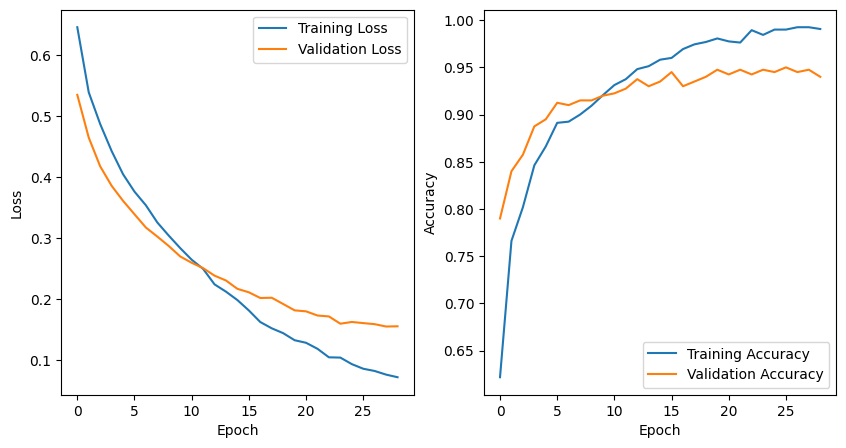

In [10]:
# Plot Losses and Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting the Test Set

In [11]:
# Predict the test dataset
all_labels, all_preds = [], []
model.eval()
total_loss = 0.0
with torch.no_grad():
  for videos, labels in tqdm(test_loader, desc="Test Loop"):
    videos, labels = videos.to(device), labels.to(device)

    outputs = model(videos)
    preds = outputs.argmax(dim=1).detach()
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

all_labels = [np.argmax(label) for label in all_labels]
acc = accuracy_score(all_labels, all_preds)

Test Loop:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
print(f"Test set accuracy is {acc}")

Test set accuracy is 0.94


              precision    recall  f1-score   support

           0       0.94      0.93      0.94       199
           1       0.94      0.95      0.94       201

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



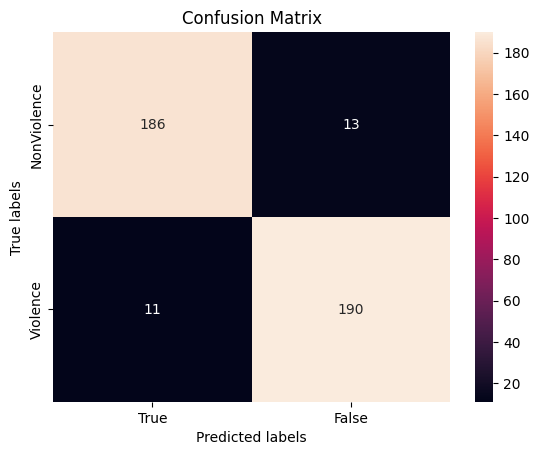

In [13]:
# Show the Classification Report and Confusion Matrix
print(classification_report(all_labels, all_preds))

ax= plt.subplot()
cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

# Predicting Random Videos From the Test Set

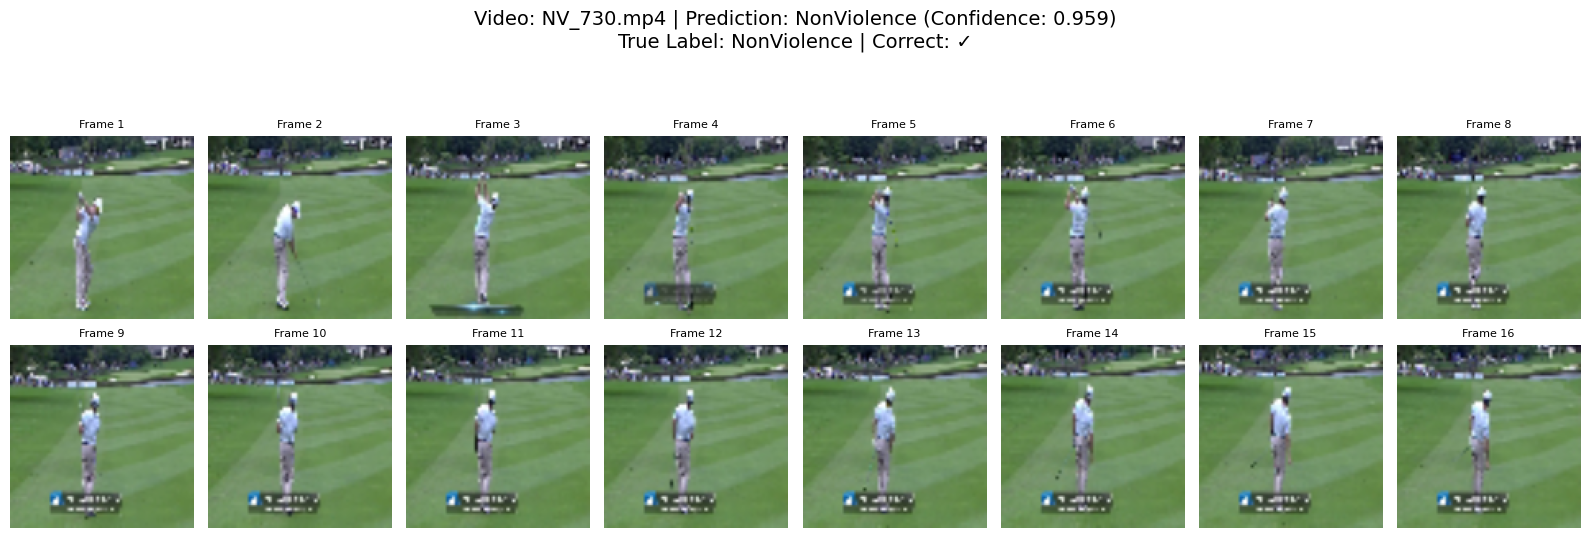

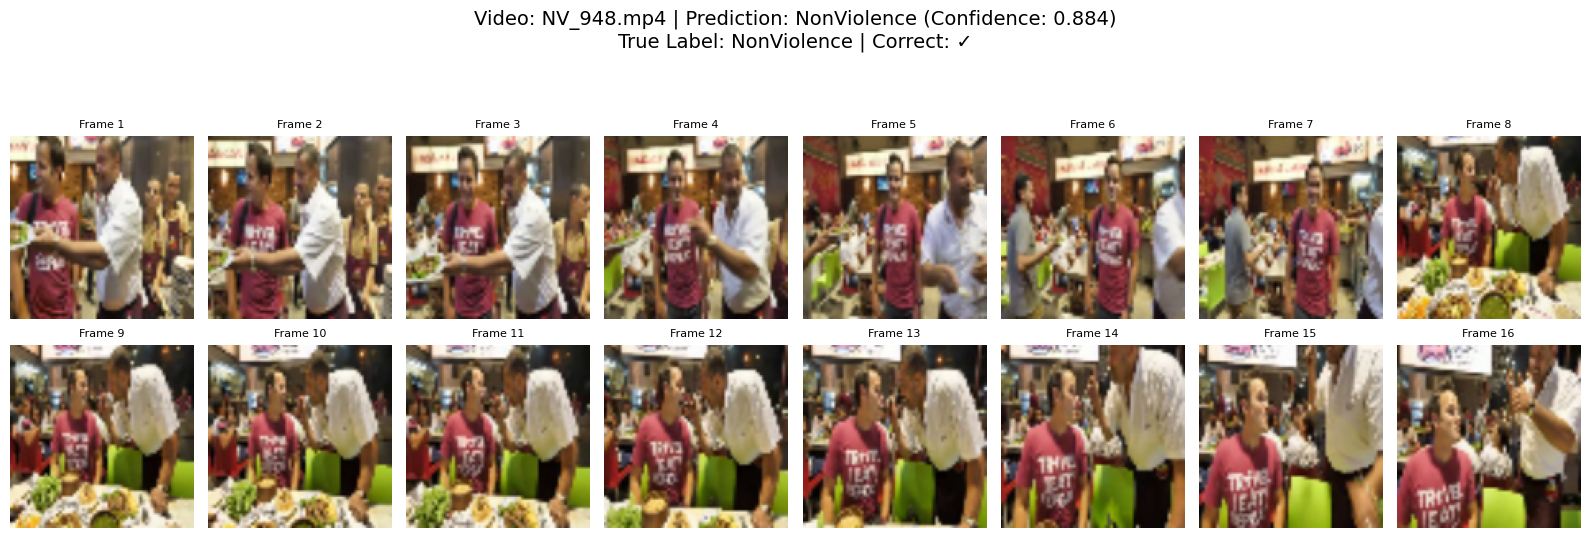

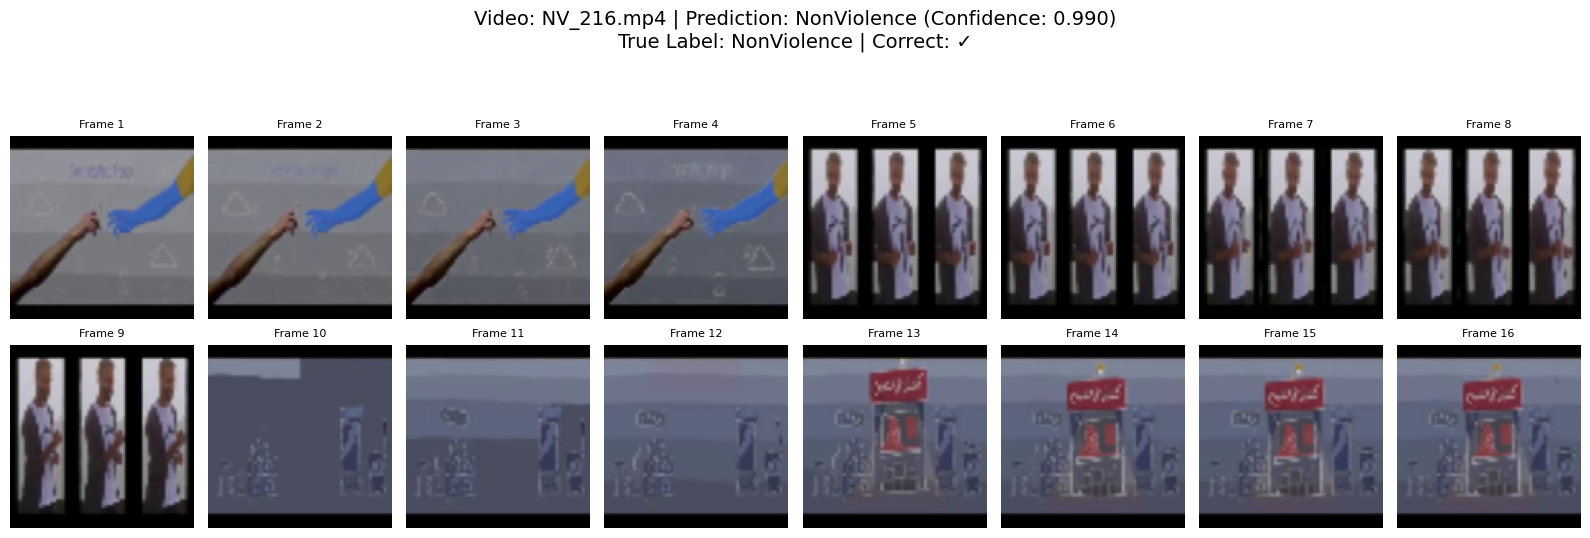

In [14]:
# Choose random indices
num_samples = 3  # or however many you want
indices = random.sample(range(len(features_test)), num_samples)

# Visualization function
def visualize_prediction(video, true_label, pred_label, confidence, video_path):
    plt.figure(figsize=(16, 6))
    plt.suptitle(
        f"Video: {video_path.split('/')[-1]} | "
        f"Prediction: {'Violence' if pred_label==1 else 'NonViolence'} "
        f"(Confidence: {confidence:.3f})\n"
        f"True Label: {'Violence' if true_label==1 else 'NonViolence'} | "
        f"Correct: {'✓' if pred_label == true_label else '✗'}",
        fontsize=14
    )

    for i, frame in enumerate(video):
        frame = frame[..., ::-1]    # fix color
        plt.subplot(2, 8, i+1)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Frame {i+1}", fontsize=8)
        border_color = 'green' if pred_label == true_label else 'red'
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run predictions and visualize
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for idx in indices:
    video = features_test[idx]  # shape: (16, 112, 112, 3)
    true_label = int(np.argmax(labels_test[idx]))
    video_tensor = torch.tensor(video).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)  # (1, 16, 3, 112, 112)

    with torch.no_grad():
      output = model(video_tensor)         # raw logits, shape: (1, 1)
      probs = nn.functional.softmax(output, dim=1)         # shape [1, 2]
      prob_value, pred_label = torch.max(probs, dim=1)  # highest probability and its index

    # Convert to scalar
    pred_label = pred_label.item()      # 0 or 1
    prob_value = prob_value.item()      # confidence (0.0 to 1.0)
    visualize_prediction(video, true_label, pred_label, prob_value, video_files_paths[idx])